In [143]:
import numpy as np
import matplotlib.pyplot as plt
import cpp_wrappers
import FRCfuncs
import os
import copy

In [12]:
type(np.array([1]))

numpy.ndarray

In [367]:
wdir = b'N:\\Singlem\\singlem19-3\\August\\05_Origami_NV_AB_JHB\\completely labelled'
file = b'Origami_TLMR_12_ROXS.ptu'
fname = os.path.join(wdir, file)
obj = processLifetimeImage(fname, uselines = np.array([1,1,1,2]))

header dir already exists
b'N:\\Singlem\\singlem19-3\\August\\05_Origami_NV_AB_JHB\\completely labelled\\header\\Origami_TLMR_12_ROXS.txt'
number of records is 248836
N:\Singlem\singlem19-3\August\05_Origami_NV_AB_JHB\completely labelled\header\Origami_TLMR_12_ROXS.txt


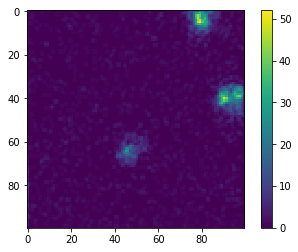

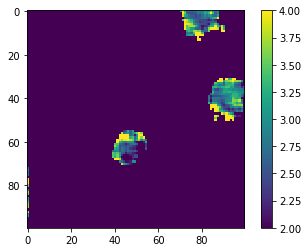

In [369]:
obj.loadLifetime()
obj.gate(26, 200)
obj.filterLifetime('smear_lifetime', 2)
obj.loadIntensity()
TLMR6_int = obj.getIntensity()
obj.loadLifetime()
obj.gate(26, 200)
obj.filterLifetime('smear_lifetime', 5)
obj.meanArrivalTime(26, 10)
TLMR6_lifetime = obj.getIntensity()
plt.imshow(TLMR6_int.G)
plt.colorbar()
plt.show()
plt.imshow(TLMR6_lifetime.G, vmin = 2, vmax = 4)
plt.colorbar()

In [339]:
plt.imshow?

In [78]:
class GRYLifetime():
    def __init__(self, imG, imR, imY):
        assert (len(imG.shape) == 3 and len(imR.shape) == 3 and len(imY.shape) == 3), \
            "arrays must be 3D"
        self.G = imG
        self.R = imR
        self.Y = imY
    
class GRYIntensity():
    def __init__(self, imG, imR, imY):
        assert (len(imG.shape) == 2 and len(imR.shape) == 2 and len(imY.shape) == 2), \
            "arrays must be 2D"
        self.G = imG
        self.R = imR
        self.Y = imY
    

In [352]:
import cpp_wrappers
import FRCfuncs
class processLifetimeImage:
    def __init__(self, fname, uselines = np.array([1,0]), Gchan = np.array([0,2]), \
        Rchan = np.array([1,3]), Ychan = np.array([1,3]), ntacs = 256, pulsetime = 25):
        self.baseLifetime = None #immutable after initialization
        self.baseIntensity = None #immutable after initialization
        self.workLifetime = None #mutable
        self.workIntensity = None #mutable
        self.ntacs = ntacs
        self.tac2time = pulsetime / ntacs #pulsetime in ns
        assert( type(uselines) == np.ndarray and \
               type(Gchan) == np.ndarray and\
               type(Rchan) == np.ndarray and \
               type(Ychan) == np.ndarray), \
            "uselines, Gchan, Ychan and Rchan must be numpy array type!"
        #initialize baseLifetimeObject
        self._makeLifetime(fname, uselines, Gchan, Rchan, Ychan, ntacs)
        #initialize baseIntensityObject
        self._makeIntensity()
        
    def gate(self, mingate, maxgate):
        self.workLifetime.G[:,:,:mingate] = 0
        self.workLifetime.G[:,:,maxgate:] = 0
        self.workLifetime.R[:,:,:mingate] = 0
        self.workLifetime.R[:,:,maxgate:] = 0
        self.workLifetime.Y[:,:,:mingate] = 0
        self.workLifetime.Y[:,:,maxgate:] = 0
        return 0
    
    def rebin(self, xfactor, yfactor):
        """reshape by xfactor and yfactor"""
        shape = self.workLifetime.G.shape
        xshape = shape[0]
        yshape = shape[1]
        nbins = shape[2]
        self.workLifetime.G = self.workLifetime.G.reshape(
            xshape // xfactor, xfactor, yshape // yfactor, yfactor, \
            nbins).sum(axis = 3).sum(axis = 1)
        self.workLifetime.R = self.workLifetime.R.reshape(
            xshape // xfactor, xfactor, yshape // yfactor, yfactor, \
            nbins).sum(axis = 3).sum(axis = 1)
        self.workLifetime.Y = self.workLifetime.Y.reshape(
            xshape // xfactor, xfactor, yshape // yfactor, yfactor, \
            nbins).sum(axis = 3).sum(axis = 1)
        return 0
    
    def filterLifetime(self, mode = 'xyz', window = 3):
        if mode == 'smear_lifetime':
            # even sized window, weighted toward + direction
            if window % 2 == 0: 
                lwindow = window // 2 - 1
                rwindow = window // 2 + 1
            #odd sized window, distributed evenly left and right
            elif window % 2 == 1: 
                lwindow = window // 2 - 1
                rwindow = window // 2 + 2
            
            ltG = self.workLifetime.G
            ltR = self.workLifetime.R
            ltY = self.workLifetime.Y
            resG = np.zeros(ltG.shape)
            resR = np.zeros(ltR.shape)
            resY = np.zeros(ltY.shape)
            xshape, yshape, _ = ltG.shape
            for i in range(xshape):
                #check boundaries
                while i - lwindow < 0:
                    lwindow -= 1
                while i + lwindow > xshape:
                    lwindow -= 1
                for j in range(yshape):
                    while j - lwindow < 0:
                        lwindow -= 1
                    while j + lwindow > xshape:
                        lwindow -= 1
                    resG[i,j] = ltG[i - lwindow : i + rwindow, 
                               j - lwindow: j + rwindow,:].sum(axis = (0,1))
                    resR[i,j] = ltR[i - lwindow : i + rwindow, 
                               j - lwindow: j + rwindow,:].sum(axis = (0,1))
                    resY[i,j] = ltY[i - lwindow : i + rwindow, 
                               j - lwindow: j + rwindow,:].sum(axis = (0,1))
            self.workLifetime.G = resG
            self.workLifetime.R = resR
            self.workLifetime.Y = resY
        return 0
            
    def meanArrivalTime(self, tacstart, threshold = 0):
        """calculates mean arrival time of workLifetime
        ignores all photons arriving bebore tacstart.
        Sets lifetime to 0 for all pixels with less than
        threshold photons."""
        weights = (np.arange(self.ntacs) - tacstart)*self.tac2time
        #ensure no negative weights. Also ensure that photons before
        #tacstart are ignored.
        for i in range(self.ntacs):
            if weights[i] < 0 :
                weights[i] = 0
        imG = np.zeros(self.workLifetime.G.shape[:2])
        imR = np.zeros(self.workLifetime.R.shape[:2])
        imY = np.zeros(self.workLifetime.Y.shape[:2])
        for i in range(imG.shape[0]):
            for j in range(imG.shape[1]):
                pixelsum = np.sum(self.workLifetime.G[i,j,:])
                if pixelsum < threshold:
                    imG[i,j] = 0
                else:
                    imG[i,j] = self.workLifetime.G[i,j,:].dot(weights) / pixelsum
                pixelsum = np.sum(self.workLifetime.R[i,j,:])
                if pixelsum < threshold:
                    imR[i,j] = 0
                else:
                    imR[i,j] = self.workLifetime.R[i,j,:].dot(weights) / pixelsum
                pixelsum = np.sum(self.workLifetime.Y[i,j,:])
                if pixelsum < threshold:
                    imY[i,j] = 0
                else:
                    imY[i,j] = self.workLifetime.Y[i,j,:].dot(weights) / pixelsum
        self.workIntensity = GRYIntensity(imG, imR, imY)
        return 0
        
    
    def filterIntensity(self, mode = 'xyz'):
        pass
    
    def lifetimeFit(self):
        pass
    
    def loadLifetime(self):
        self.workLifetime = copy.deepcopy(self.baseLifetime)
        return 0
        
    def loadIntensity(self):
        imG = self.workLifetime.G.sum(axis=2)
        imR = self.workLifetime.R.sum(axis=2)
        imY = self.workLifetime.Y.sum(axis=2)
        self.workIntensity = GRYIntensity(imG, imR, imY)
        return 0
    
    def getLifetime(self):
        return self.workLifetime
    
    def getIntensity(self):
        return self.workIntensity
    
    def setLifetime(self, LifetimeObject):
        assert(type(LifetimeObject = GRYLifetime)),'not a GRY lifetime object'
        self.workLifetime = LifetimeObject
        return 0
        
    def setIntensity(self, IntensityObject):
        assert(type(IntensityObject = GRYIntensity)),'not a GRY intensity object'
        self.workIntensity = IntensityObject
        return 0
        
    def _makeIntensity(self):
        """sum tac histograms to obtain intensity image"""
        imG = self.baseLifetime.G.sum(axis=2)
        imR = self.baseLifetime.R.sum(axis=2)
        imY = self.baseLifetime.Y.sum(axis=2)
        self.baseIntensity = GRYIntensity(imG, imR, imY)
        return 0
    
    
    
    def _makeLifetime(self, fname, uselines, Gchan, Rchan, Ychan, ntacs):
        """initialisation routine for lifetime image manipulation class.
        Loads the .ptu file located at fname.
        Uselines codes for the used line steps. 
            0 denotes that the line is ignored
            1 denotes that the line is FRET sensitized
            2 denotes that it is PIE sensitized
        Uselines should not be used for binning. A separate functions exists for 
            that.
        Gchan, Rchan and Ychan indicates the detection channels for the 
            corresponding colors. No distinction between P and S 
            polarisation is made. Generally R and Y have the same channels.
        ntacs is the amount of bins used for the tac histogram. Decrease 
            to safe memory usage. Computational efficiency is minimal
            effected.
        returns imG, imR, imY"""
        uselines = uselines.astype(np.ubyte)
        Gchan = Gchan.astype(np.ubyte)
        Rchan = Rchan.astype(np.ubyte)
        Ychan = Ychan.astype(np.ubyte)
        root, file = os.path.split(fname)
        NumRecords = cpp_wrappers.ptuHeader_wrap (fname)
        eventN, tac, t, can = cpp_wrappers.ptu_wrap(fname, NumRecords)
        root, file = os.path.split(fname)
        name, _ = os.path.splitext(file)
        header_name = os.path.join(root, b"header", name + b".txt")
        print('number of records is ' + str(NumRecords))

        dimX, dimY, dwelltime, counttime = cpp_wrappers.read_header(header_name)
        imG, imR, imY = cpp_wrappers.genGRYLifetimeWrap(eventN, tac, t, can, dimX, dimY, ntacs, \
            dwelltime, counttime, NumRecords, uselines, Gchan, Rchan, Ychan)
        self.baseLifetime = GRYLifetime(imG, imR, imY)
        return 0

In [323]:
a = np.arange(10)
b = np.arange(10)
a.dot(b)

285

In [325]:
a = np.arange(8).reshape(2,2,2)
b = np.arange(2)
print(a)
print(b)
np.tensordot(a,b,axes = 1)

[[[0 1]
  [2 3]]

 [[4 5]
  [6 7]]]
[0 1]


array([[1, 3],
       [5, 7]])

In [328]:
a[0,0,:]

array([0, 1])

In [204]:
a = np.arange(160).reshape(4,4,10)

a.reshape(2,2,2,2,10).sum(axis=3).sum(axis=1)
print(a)

[[[  0   1   2   3   4   5   6   7   8   9]
  [ 10  11  12  13  14  15  16  17  18  19]
  [ 20  21  22  23  24  25  26  27  28  29]
  [ 30  31  32  33  34  35  36  37  38  39]]

 [[ 40  41  42  43  44  45  46  47  48  49]
  [ 50  51  52  53  54  55  56  57  58  59]
  [ 60  61  62  63  64  65  66  67  68  69]
  [ 70  71  72  73  74  75  76  77  78  79]]

 [[ 80  81  82  83  84  85  86  87  88  89]
  [ 90  91  92  93  94  95  96  97  98  99]
  [100 101 102 103 104 105 106 107 108 109]
  [110 111 112 113 114 115 116 117 118 119]]

 [[120 121 122 123 124 125 126 127 128 129]
  [130 131 132 133 134 135 136 137 138 139]
  [140 141 142 143 144 145 146 147 148 149]
  [150 151 152 153 154 155 156 157 158 159]]]


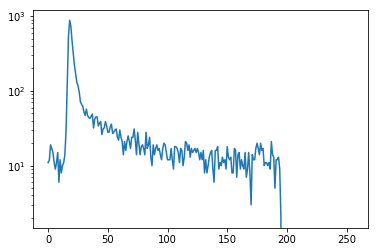

In [3]:
int_imG = imG.sum(axis = 2)
int_imR = imY.sum(axis = 2)
#plt.imshow(imG.sum(axis=2))
plt.plot(imR.sum(axis=(0,1)))
ax = plt.gca()
ax.set_yscale('log')

In [27]:
len(imY.shape)

3